# [Mercari Price Suggestion Challenge](https://www.kaggle.com/c/mercari-price-suggestion-challenge)
Can you automatically suggest product prices to online sellers?

# Import packages

In [1]:
import pandas as pd #data processing
import numpy as np #linear algebra
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram

%matplotlib inline
import matplotlib.pyplot as plt #commonly used visualization tool
import seaborn as sns #new visualization tool
from string import ascii_letters
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler

# Import data

set train and test data, split by tab because of the tsv format.

In [2]:
%%time
train_df = pd.read_csv("data/train_df.csv", low_memory= True)
test_df = pd.read_csv("data/test_df.csv", low_memory= True)

CPU times: user 11.4 s, sys: 1.29 s, total: 12.7 s
Wall time: 11.7 s


In [3]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_category,subcategory_1,subcategory_2,char_count,word_count,word_density,top_tfidf_word,top_tfidf_value
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NoBrand,10.0,1,No description yet,Men,Tops,T-shirts,18,3,4.500000,None,0.000000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,188,36,5.081081,None,0.000000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,124,29,4.133333,None,0.000000
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NoBrand,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,173,32,5.242424,foot,7.317186
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NoBrand,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,41,5,6.833333,None,0.000000


In [4]:
test_df.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_category,subcategory_1,subcategory_2,char_count,word_count,word_density,top_tfidf_word,top_tfidf_value
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NoBrand,1,Size 7,Women,Jewelry,Rings,6,2,2.000000,None,0.000000
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NoBrand,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies,251,38,6.435897,peel,7.245109
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag,55,11,4.583333,None,0.000000
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NoBrand,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan,67,10,6.090909,None,0.000000
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NoBrand,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality,167,29,5.566667,None,0.000000


In [5]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_category',
       'subcategory_1', 'subcategory_2', 'char_count', 'word_count',
       'word_density', 'top_tfidf_word', 'top_tfidf_value'],
      dtype='object')

In [6]:
print('Train shape: {}\nTest shape: {}'.format(train_df.shape, test_df.shape))

Train shape: (1482535, 16)
Test shape: (693359, 15)


# Log Normalization

In [7]:
train_df.var().map('{:.2f}'.format)

train_id             183159292396.39
item_condition_id               0.82
price                        1488.88
shipping                        0.25
char_count                  30431.55
word_count                    923.77
word_density                    0.78
top_tfidf_value                 8.71
dtype: object

train_id with high variance doesn't make sense, but char_count is what we are going to deal woth.

In [8]:
np.log(train_df["char_count"]).var()

1.2135370293092482

In [9]:
train_df["log_price"] = np.log(train_df["price"])
test_df["log_price"] = np.log(test_df["price"])

train_df["log_char_count"] = np.log(train_df["char_count"])
test_df["log_char_count"] = np.log(test_df["char_count"])

In [10]:
train_df.var().map('{:.2f}'.format)

train_id             183159292396.39
item_condition_id               0.82
price                        1488.88
shipping                        0.25
char_count                      1.21
word_count                    923.77
word_density                    0.78
top_tfidf_value                 8.71
dtype: object

# Exploratory Data Analysis (EDA)

In [11]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_category,subcategory_1,subcategory_2,char_count,word_count,word_density,top_tfidf_word,top_tfidf_value
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NoBrand,10.0,1,No description yet,Men,Tops,T-shirts,2.890372,3,4.500000,None,0.000000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,5.236442,36,5.081081,None,0.000000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,4.820282,29,4.133333,None,0.000000
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NoBrand,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,5.153292,32,5.242424,foot,7.317186
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NoBrand,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.713572,5,6.833333,None,0.000000


In [12]:
train_df.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'general_category',
       'subcategory_1', 'subcategory_2', 'char_count', 'word_count',
       'word_density', 'top_tfidf_word', 'top_tfidf_value'],
      dtype='object')

## countplots

most of the products are women products

In [13]:
train_df["general_category"].value_counts()

Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
No                          6327
Name: general_category, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

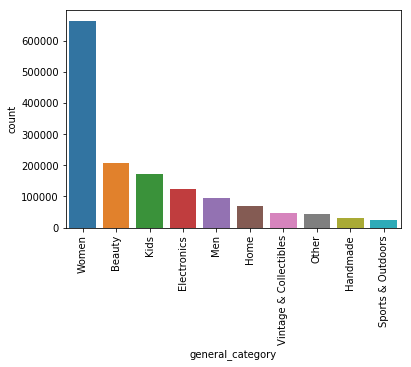

In [14]:
sns.countplot(x="general_category", data=train_df, 
              order=pd.value_counts(train_df["general_category"]).iloc[:10].index)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

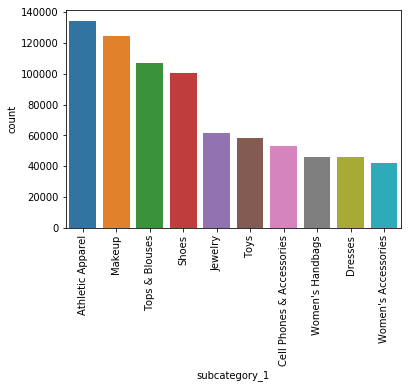

In [15]:
sns.countplot(x="subcategory_1", data=train_df, 
              order=pd.value_counts(train_df["subcategory_1"]).iloc[:10].index)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

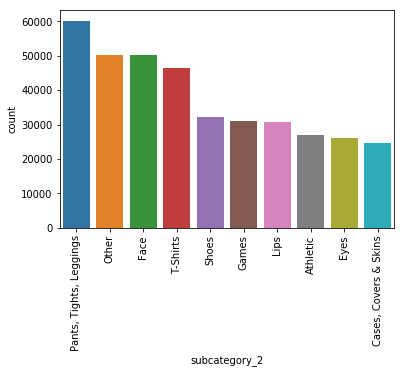

In [16]:
sns.countplot(x="subcategory_2", data=train_df, 
              order=pd.value_counts(train_df["subcategory_2"]).iloc[:10].index)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

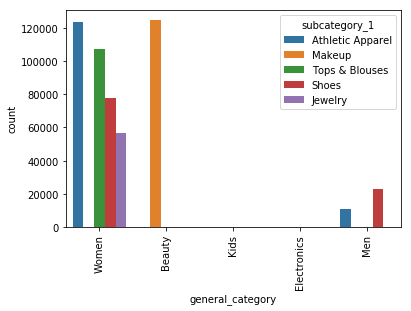

In [17]:
sns.countplot(x="general_category", data=train_df, hue="subcategory_1", 
              hue_order=pd.value_counts(train_df["subcategory_1"]).iloc[:5].index,
              order=pd.value_counts(train_df["general_category"]).iloc[:5].index)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

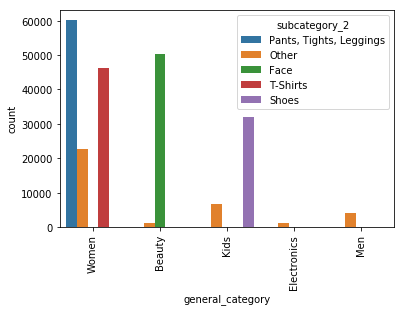

In [18]:
sns.countplot(x="general_category", data=train_df, hue="subcategory_2", 
              hue_order=pd.value_counts(train_df["subcategory_2"]).iloc[:5].index,
              order=pd.value_counts(train_df["general_category"]).iloc[:5].index)
plt.xticks(rotation=90)

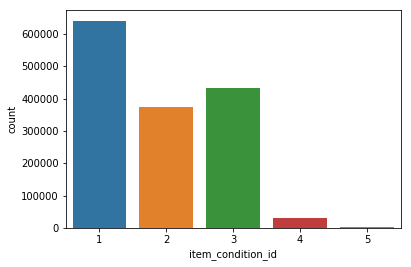

In [19]:
sns.countplot(x="item_condition_id", data=train_df)

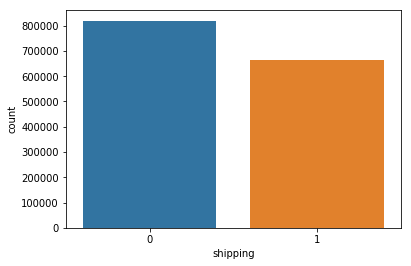

In [20]:
sns.countplot(x="shipping", data=train_df)

## scatter plots

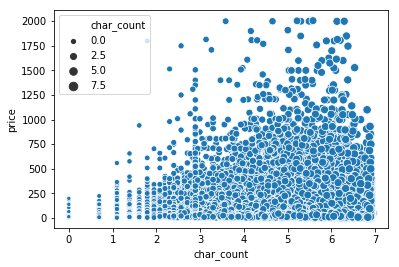

In [21]:
sns.scatterplot(x="char_count", y="price", data=train_df, size="char_count")

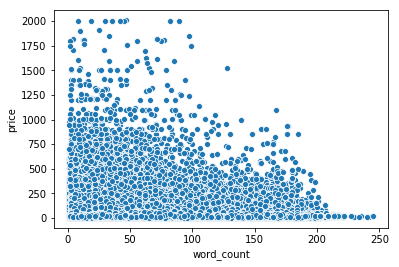

In [22]:
sns.scatterplot(x="word_count", y="price", data=train_df)

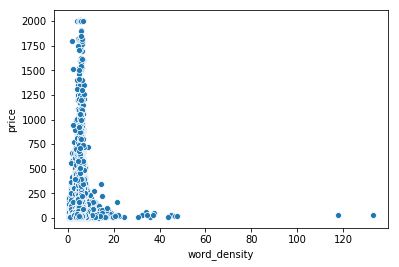

In [23]:
sns.scatterplot(x="word_density", y="price", data=train_df)

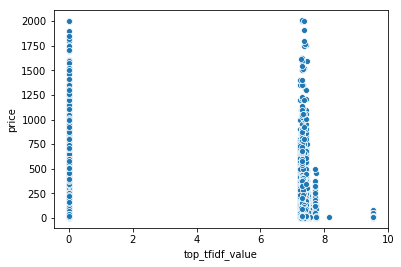

In [24]:
sns.scatterplot(x="top_tfidf_value", y="price", data=train_df)

### regression plots

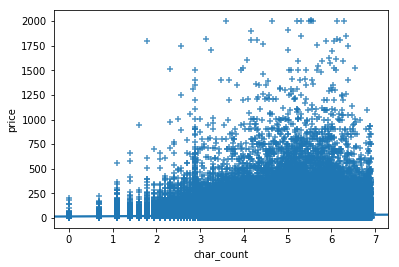

In [25]:
sns.regplot(x="char_count", y="price", data=train_df, marker="+")

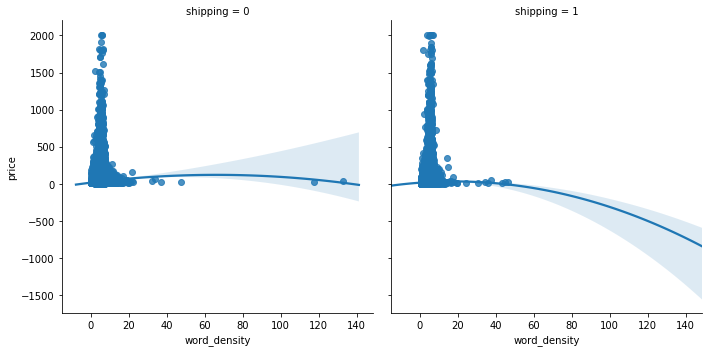

In [26]:
sns.lmplot(x="word_density", y="price", data=train_df, order=2, col="shipping")

In [27]:
train_df.nunique().sort_values(ascending=False)

train_id             1482535
item_description     1281426
name                 1225273
word_density           20778
brand_name              4810
category_name           1288
char_count              1016
subcategory_2            872
price                    828
word_count               228
subcategory_1            114
top_tfidf_word           100
top_tfidf_value           92
general_category          11
item_condition_id          5
shipping                   2
dtype: int64

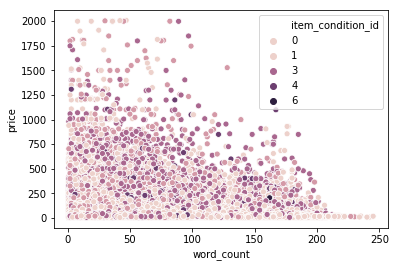

In [28]:
sns.scatterplot(x="word_count", y="price", data=train_df, hue="item_condition_id")

## distribution plots

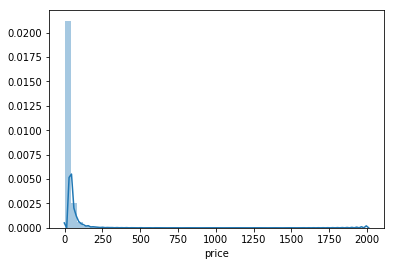

In [41]:
sns.distplot(train_df["price"], bins=50)

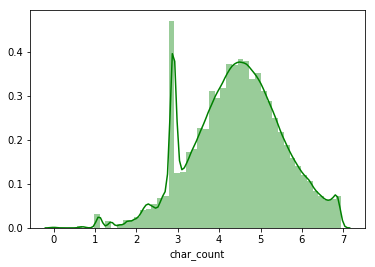

In [30]:
sns.distplot(train_df["char_count"], color="g")

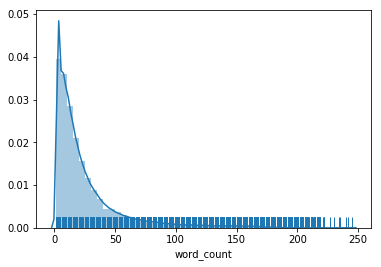

In [31]:
sns.distplot(train_df["word_count"], rug=True)

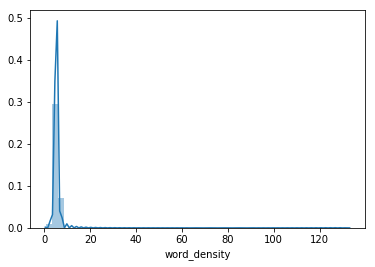

In [32]:
sns.distplot(train_df["word_density"])

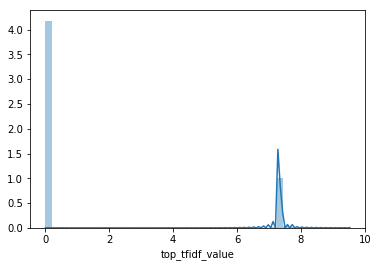

In [33]:
sns.distplot(train_df["top_tfidf_value"])

## heatmaps

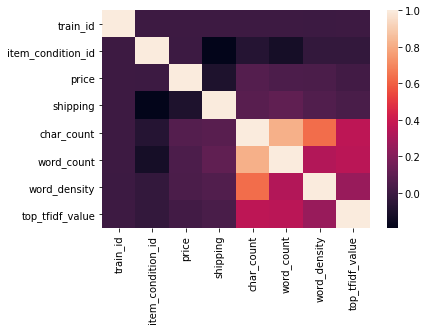

In [42]:
sns.heatmap(train_df.corr())

## box plots

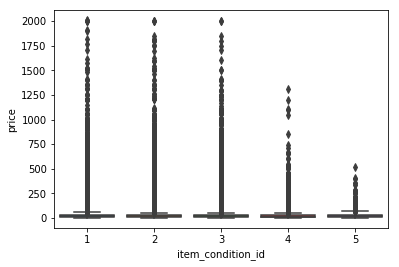

In [43]:
sns.boxplot(data=train_df, x="item_condition_id", y="price")

## violin plots

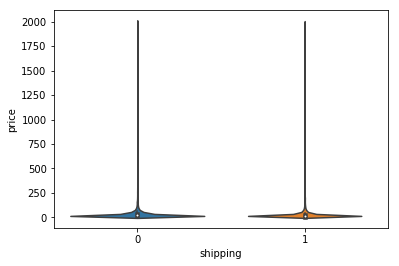

In [44]:
sns.violinplot(data=train_df, x="shipping", y="price")

## lvplots

/Users/JackChang/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:2612: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please 

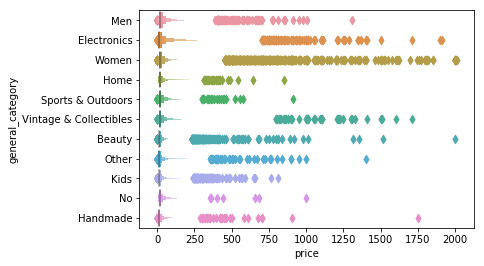

In [45]:
sns.lvplot(data=train_df, y="general_category", x="price")

## stripplots

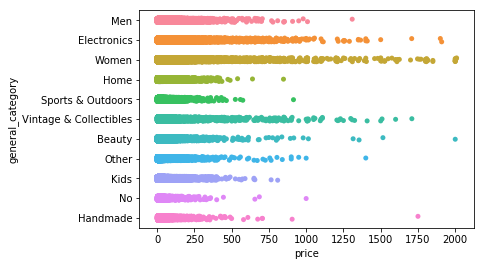

In [46]:
sns.stripplot(data=train_df, y="general_category", x="price", jitter=True)

## swarmplots

In [55]:
#sns.swarmplot(data=train_df, y="word_count", hue="shipping")

## pointplot

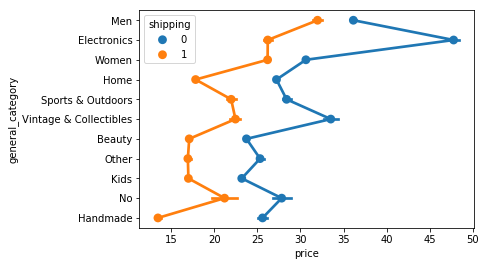

In [49]:
sns.pointplot(data=train_df, y="general_category", x="price", hue="shipping")

In [52]:
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_category,subcategory_1,subcategory_2,char_count,word_count,word_density,top_tfidf_word,top_tfidf_value
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NoBrand,10.0,1,No description yet,Men,Tops,T-shirts,2.890372,3,4.500000,None,0.000000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,5.236442,36,5.081081,None,0.000000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,4.820282,29,4.133333,None,0.000000
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NoBrand,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,5.153292,32,5.242424,foot,7.317186
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NoBrand,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3.713572,5,6.833333,None,0.000000


用plt做hist，觀察出price大部分小於50

In [ ]:
train_df.price.plot.hist(bins=50, figsize=(8,4), edgecolor='white',range=[0,300])
plt.title('Price Distribution')

In [ ]:
np.log(train_df['price']+1).plot.hist(bins=50, figsize=(8,4), edgecolor='white')
plt.title('Price Distribution (log price +1 )')

price本身平均在30，中位數20
<br>這告訴我們訂價大部分介於100以內，但還是有到2009的

In [ ]:
train_df['price'].describe()

用seaborn原本要用出個別表格，沒分割的結果...

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.countplot('general_category',data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of each general category')

大部分狀態1到3

In [ ]:
ax = sns.countplot('item_condition_id',data=train_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of each item condition')

In [ ]:
ax = sns.countplot(x="item_condition_id", hue="general_category", data=train_df, palette="Set3")
ax.set_title('Count of each item condition by general category')

突然想算個Pearson相關係數

In [ ]:
train_df.corr()

Kendall Tau相關係數

In [ ]:
train_df.corr('kendall')

Spearman相關係數

In [ ]:
train_df.corr('spearman')

In [ ]:
print(train_df['brand_name'].nunique())

In [ ]:
train_df.brand_name.value_counts()[:10]

展示個文字雲，這是item_description的

In [ ]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_df['item_description']
.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

再做一個category_name的

In [ ]:
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_df['category_name']
.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
ax = sns.boxplot(x="general_category", y="item_condition_id", data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Condition distribution by general category')

plt.tight_layout()

In [ ]:
ax = sns.boxplot(x="general_category", y="price", data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_yscale('log')
ax.set_title('Price distribution by general category')

plt.tight_layout()

In [ ]:
ax = sns.countplot(x="general_category", hue="shipping", data=train_df, palette="Set3")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Count of shipping by general category')

In [ ]:
ax = sns.boxplot(x="shipping", y="price", data=train_df)
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Price distribution by shipping')

In [ ]:
ax = sns.violinplot(x='general_category', y='price', hue='shipping', data=train_df, palette="Pastel1",legend_out=False)
plt.legend(loc='lower left')
ax.set_yscale('log')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('Price distribution by general category and shipping')

In [ ]:
print(train_df.groupby(['subcategory_1'])["price"].mean().sort_values(ascending=False)[:10])
print("------------")
print(train_df.groupby(['subcategory_2'])["price"].mean().sort_values(ascending=False)[:10])

In [ ]:
train_df.groupby(['brand_name'])["price"].mean().sort_values(ascending=False)[:10]

In [ ]:
train_df.item_description = train_df.item_description.fillna('Empty')
train_df['log_price'] = np.log(train_df['price']+1)

train_df['des_len'] = train_df.item_description.apply(lambda x : len(x))

df = train_df.groupby(['des_len'])['log_price'].mean().reset_index()

plt.plot('des_len','log_price', data=df, marker='o', color='mediumvioletred')

In [ ]:
train_df['name_len'] = train_df.name.apply(lambda x : len(x))

df = train_df.groupby(['name_len'])['log_price'].mean().reset_index()

plt.plot('name_len','log_price', data=df, marker='o', color='mediumvioletred')

In [ ]:
test_df['des_len'] = test_df.item_description.apply(lambda x : len(x))
test_df['name_len'] = test_df.name.apply(lambda x : len(x))
#test_df['log_price'] = np.log(test_df['price']+1)